## Project 1.2 - Results and Limits

Group: Emmy Noether

Students: Janik Rausch (628334), Camilo Tello Breuer (633291), Ida Wöstheinreich (628428)

In [2]:
using LinearAlgebra,Random,Printf,JLD,Plots,LaTeXStrings,Colors
include("Ground_state.jl")

ground_state (generic function with 1 method)

**1D Potential and Ground State**

Energy: 4.86106e-01 ± 1.81365e-05
Position: (2.23405e+00) ± (3.06946e+01)
Momentum: (1.17050e-06) ± (9.68434e-02)
Half-space probability: 5.36819e-01

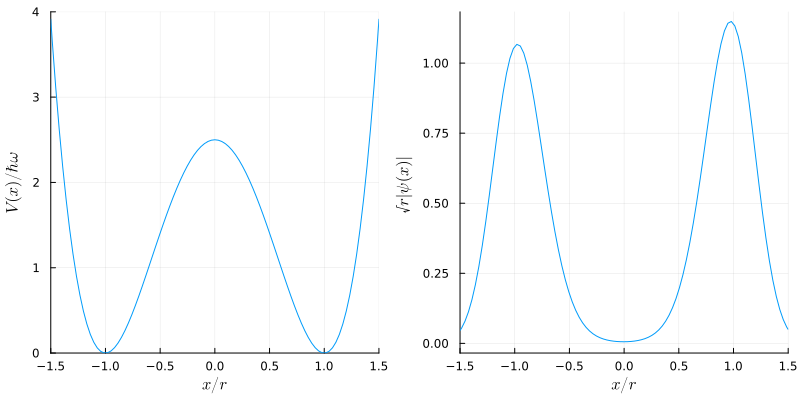

In [3]:
N = 200
μ, ϵ = 20, sqrt(0.001)
#cool plot: 51, 1, 0.07
#for one dimension
E_min, ψ_min = ground_state((N,), μ, ϵ, 1e-5, 10000, 1e-5, 1000)
#save("Ground_state_" * string(N,"_",1) * ".jld", "psi", ψ_min)

n = lattice(N, 1) #use ! to add something to the last plot
p_1 = plot(n*ϵ, potential(μ, ϵ, n), label = "")#multiply n = x/a, ϵ = a/r you want units of r true physical values, potential is V/ħω
xlabel!(L"x/r"); ylabel!(L"V\,(x)/\hbar\omega")
ylims!(0,4); xlims!(-1.5, 1.5)
p_2 = plot(n*ϵ, abs.(ψ_min)/sqrt(ϵ), label = "")#ψ is in units of 1/√a so  
xlabel!(L"x/r"); ylabel!(L"√r|\psi\,(x)|")
xlims!(-1.5, 1.5)

p = plot(p_1, p_2, layout = (1,2), size = (800,400), left_margin = 3Plots.mm, bottom_margin = 3Plots.mm) #layout is to order the plts 
display(p) #aquivalent to pyplot.show 

The ground state wavefunction isn't symmetric, and is not exactly reproduced when running the code multiple times:

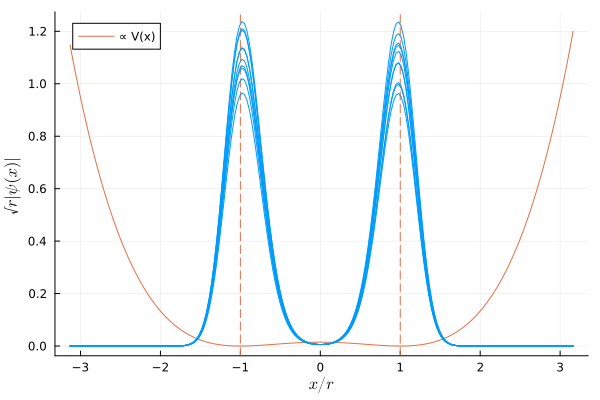

In [7]:
N = 200
μ, ϵ = 20, sqrt(0.001)

n = lattice(N, 1); V = potential(μ, ϵ, n)
p = plot(n*ϵ, V/max(V...) * 1.2, color = 2, label = "∝ V(x)")
vline!([1, -1], color = 2, label = "", linestyle = :dash)
xlabel!(L"x/r"); ylabel!(L"√r|\psi\,(x)|")

for i in 1:10
    E_min, ψ_min = ground_state((N,), μ, ϵ, 1e-5, 10000, 1e-5, 1000; verbose = false)
    plot!(n*ϵ, abs.(ψ_min)./sqrt(ϵ), color = 1, label = "")
end

display(p)

The values near the potential minima (at $x/r=\pm 1$) appear to oscillate randomly. For smaller values of $\mu$ (i.e. decreased potential) this effect is less pronounced. This suggests that it is due to the (almost) vanishing of the wavefunction between the potential minima for large $\mu$, which means that there is very little interaction between the two sides.

To probe this further, we compute the ground state starting from one-sided initial guesses.

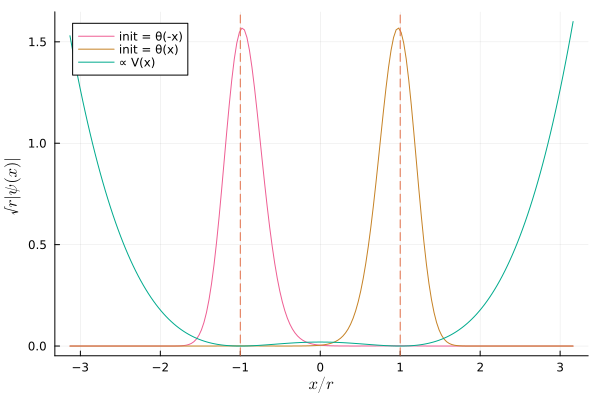

Energies: 4.86113e-01, 4.86113e-01

In [9]:
N = 200
μ, ϵ = 20, sqrt(0.001)

init_l = vcat(fill(1, (round(Int, N/2),)), fill(0, (round(Int, N/2),)))
init_r = vcat(fill(0, (round(Int, N/2),)), fill(1, (round(Int, N/2),)))
E_l, ψ_l = ground_state((N,), μ, ϵ, 1e-5, 10000, 1e-5, 1000; init = init_l, verbose = false)
E_r, ψ_r = ground_state((N,), μ, ϵ, 1e-5, 10000, 1e-5, 1000; init = init_r, verbose = false)

n = lattice(N, 1)
p = plot(n*ϵ, abs.(ψ_l)./sqrt(ϵ), color = 7, label = "init = θ(-x)")
plot!(n*ϵ, abs.(ψ_r)./sqrt(ϵ), color = 8, label = "init = θ(x)")
xlabel!(L"x/r"); ylabel!(L"√r|\psi\,(x)|")

V = potential(μ, ϵ, n)
plot!(n*ϵ, V/max(V...) * 1.6, color = 9, label = "∝ V(x)")
vline!([1, -1], color = 2, label = "", linestyle = :dash)

display(p)
@printf "Energies: %.5e, %.5e" E_l E_r

We get eigenfunctions which are almost completely located around one of the potential minima, with eigenvalues which are very close to the one above. The difference is due to the small interaction between the two sides.

This explains the oscillation of the wavefunction: The energy eigenvalues become approximately degenerated (within the power method tolerance) since linear combinations of similar one-sided eigenfunctions are again eigenfunctions. Thus, the result for the ground state wavefunction depends on the random initial guess.

To avoid this, we can decrease the tolerances, or simply start from a symmetric initial wavefunction (which is justified since the whole problem is symmetric).

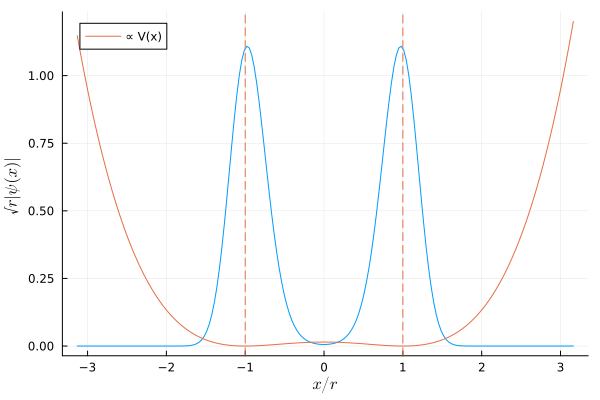

Energy: 4.86106e-01

In [34]:
N = 200
μ, ϵ = 20, sqrt(0.001)

E_sym, ψ_sym = ground_state((N,), μ, ϵ, 1e-5, 10000, 1e-5, 1000; init = fill(1, (N,)), verbose = false)

n = lattice(N, 1)
p = plot(n*ϵ, abs.(ψ_sym)./sqrt(ϵ), color = 1, label = "")
xlabel!(L"x/r"); ylabel!(L"√r|\psi\,(x)|")

V = potential(μ, ϵ, n)
plot!(n*ϵ, V/max(V...) * 1.2, color = 2, label = "∝ V(x)")
vline!([1, -1], color = 2, label = "", linestyle = :dash)

display(p)
@printf "Energy: %.5e" E_sym

Now the result for the ground state is symmetric, with a slightly lower eigenvalue than the one-sided results. From here, we will always use a symmetric initial guess.

This problem shouldn't arise if $D>1$ since in that case, the points where the potential is minimal (i.e. the $(D-1)$-sphere where $\textbf{x}^2=r^2$) aren't disconnected from another.

**Infinite-Volume Limit**

This limit is realized by increasing $N$ while keeping all other parameters constant.

In [35]:
ΔN, steps = 20, 12
N_0 = 30
μ, ϵ = 20, sqrt(0.001)

rect(x, y, w, h) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

anim = @animate for step in 0:steps
    N = N_0 + ΔN*step
    E_min, ψ_min = ground_state((N,), μ, ϵ, 1e-5, 10000, 1e-5, 10000; init = fill(1, (N,)), verbose = false)
    
    n = lattice(N, 1)
    s = step/steps; c = RGB(0.6*s, 0.75*(1-s), 1.0-0.2*s)
    fmt = Printf.Format("L/r = %.1f")
    plot(n*ϵ, abs.(ψ_min)./sqrt(ϵ), label = Printf.format(fmt, N*ϵ), color = c)
    xlabel!(L"x/r"); ylabel!(L"√r|\psi\,(x)|")
    xlims!((-5,5)); ylims!((0,1.3))
    
    V = potential(μ, ϵ, n)
    plot!(n*ϵ, V * 1e-3, color = 2, label = "∝ V(x)")
    vline!([-1, 1], color = 2, label = "", linestyle = :dash)
    plot!(rect(-N/2*ϵ, 0, -6, 1.4), alpha = 0.5, c = "dimgray", label = "")
    plot!(rect(N/2*ϵ, 0, 6, 1.4), alpha = 0.5, c = "dimgray", label = "")
end

gif(anim, "Infinite_Volume_Limit.gif", fps = 2)

The wavefunction converges very quickly after the point where both potential minima lie within the system.

**Continuum Limit**

This limit is realized by decreasing $\epsilon$ while keeping the system size $L\propto\epsilon N$ constant.

In [ ]:
factor, steps = 4/5, 12
ϵ_0, N_0 = 0.4, 100
μ = 20

anim = @animate for step in 0:steps
    ϵ = ϵ_0 * factor^step
    N = round(Int, N_0 / (factor^step))
    E_min, ψ_min = ground_state((N,), μ, ϵ, 1e-4, 10000, 1e-4, 100000; init = fill(1, (N,)), verbose = false)
    
    n = lattice(N, 1)
    s = step/steps; c = RGB(0.6*s, 0.75*(1-s), 1.0-0.2*s)
    fmt = Printf.Format("ϵ = %.2e")
    plot(n*ϵ, abs.(ψ_min)./sqrt(ϵ), label = Printf.format(fmt, ϵ), color = c)
    xlabel!(L"x/r"); ylabel!(L"√r|\psi\,(x)|")
    xlims!((-5,5)); ylims!((0,1.3))
    
    V = potential(μ, ϵ, n)
    plot!(n*ϵ, V * 1e-3, color = 2, label = "∝ V(x)")
    vline!([1, -1], color = 2, label = "", linestyle = :dash)
end

gif(anim, "Continuum_Limit.gif", fps = 2)

Again, the wavefunction converges fairly quickly.

**2D Potential and Ground State**

In [ ]:
N = 200
μ, ϵ = 20, sqrt(0.001)
#cool plot: 21, 1, 0.12

E_min, ψ_min = ground_state((N,N), μ, ϵ, 1e-5, 10000, 1e-5, 1000)
#save("Ground_state_" * string(N,"_",2) * ".jld", "psi", ψ_min)

n_1D = lattice(N, 1); n = lattice(N, 2)
p_1 = surface(n_1D*ϵ, n_1D*ϵ, potential(μ, ϵ, n), legend = nothing)
xlabel!(L"x/r"); ylabel!(L"y/r"); zlabel!(L"V\,(\textbf{x})/\hbar\omega")
p_2 = surface(n_1D*ϵ, n_1D*ϵ, abs.(ψ_min)./ϵ, legend = nothing)
xlabel!(L"x/r"); ylabel!(L"y/r"); zlabel!(L"r|\psi\,(\textbf{x})|")

p = plot(p_1, p_2, layout = (1,2), size = (800,400))
display(p)

It seems that the 2D ground state is similar to what you would obtain by rotating the 1D result about the vertical axis, which could have been expected due to the spherical symmetry of the problem. You can also see that the energy degeneracy problem from before doesn't appear since the wavefunction is constant along the circle of minima.

To compare to the 1D result, we plot slices of the result along the x- and y-axes (where $n_y=0$ and $n_x=0$ respectively).

In [ ]:
N = 200
μ, ϵ = 20, sqrt(0.001)

E_1D, ψ_1D = ground_state((N,), μ, ϵ, 1e-5, 10000, 1e-5, 1000; init = fill(1, (N,)), verbose = false)
E_2D, ψ_2D = ground_state((N,N), μ, ϵ, 1e-5, 10000, 1e-5, 1000; verbose = false)

n = lattice(N, 2)
ind_x = findall(x -> x[2] == 0, n)
ind_y = findall(x -> x[1] == 0, n)
n_x = map(x -> x[1], n[ind_x])
n_y = map(x -> x[2], n[ind_y])

ψ_2D = ψ_2D * norm(ψ_1D, Inf)/norm(ψ_2D, Inf)

p = plot(lattice(N, 1)*ϵ, abs.(ψ_1D)./sqrt(ϵ), color = 1, label = "1D result")
plot!(n_x*ϵ, abs.(ψ_2D[ind_x])./sqrt(ϵ), color = 3, label = "2D slice along x")
plot!(n_y*ϵ, abs.(ψ_2D[ind_y])./sqrt(ϵ), color = 3, label = "2D slice along y")
xlabel!(L"x/r"); ylabel!(L"\propto\,|\psi\,(x)|")

V = potential(μ, ϵ, lattice(N, 1))
plot!(n_x*ϵ, V/max(V...) * 1.2, color = 2, label = "∝ V(x)")
vline!([1, -1], color = 2, label = "", linestyle = :dash)

display(p)

The different 2D slices agree very closely with each other, showing the rotational symmetry of the wavefunction. They are also fairly close to the 1D result (after appropriate rescaling).